In [40]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.widgets import Slider, Button
import cv2
import os

# How to use:

This notebook is meant to be used as a debugging tool to visualise the transforms between a fixed frame and relative frame. In this case, this is the base_link and camera_frame. 

We can also view the projected image points into the image frame. 

When the waypoint_publisher node is updated, it will automatically overwrite a waypoint.npy file used by the Depth Image Projection Class. 

Key learnings:
- The position of camera, including its orientation, heavily impacts re-projected world points.
- The distance from when the ground plane can first be seen in the image is important. This is also related to the   orientation of the camera. This is why there was a fixed offset introduced to the waypoints in the x-direction     which can be seen in waypoint_publisher.py

## Depth Image Projection Class

In [36]:
class DepthProjection:
    def __init__(self):
        self.trajectories = np.load("../params/waypoints.npy") 
        self.K = np.load("../params/intrinsic.npy")
        self.camera_points = None
        ## These params must match waypoint_publisher.py
        self.IM_WIDTH = 640
        self.IM_HEIGHT = 480
        self.num_traj = 16
        self.sampling = 10
        
        ## These are defined in the tf topic -> orientation and position between base_link and camera_frame
        self.Q = np.array([-0.5,0.5,-0.5,0.5]) 
        self.tvec = np.array([[-0.065,0,0.255]])
        
    def set_trajectories(self):
        '''
        Create homogenous trajectories for transformation 
        '''
        self.trajectories = self.trajectories.T
        homogen = np.ones(self.trajectories.shape[1])
        self.trajectories = np.vstack([self.trajectories,homogen])
        self.camera_points = np.zeros_like(self.trajectories)

    def quaternion_rotation_matrix(self,Q):
        '''
        Input
        :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 

        Output
        :return: A 3x3 element matrix representing the full 3D rotation matrix. 
                 This rotation matrix converts a point in the local reference 
                 frame to a point in the global reference frame.
        
        '''      
        # Extract the values from Q
        q0 = Q[0]
        q1 = Q[1]
        q2 = Q[2]
        q3 = Q[3]

        # First row of the rotation matrix
        r00 = 2 * (q0 * q0 + q1 * q1) - 1
        r01 = 2 * (q1 * q2 - q0 * q3)
        r02 = 2 * (q1 * q3 + q0 * q2)

        # Second row of the rotation matrix
        r10 = 2 * (q1 * q2 + q0 * q3)
        r11 = 2 * (q0 * q0 + q2 * q2) - 1
        r12 = 2 * (q2 * q3 - q0 * q1)

        # Third row of the rotation matrix
        r20 = 2 * (q1 * q3 - q0 * q2)
        r21 = 2 * (q2 * q3 + q0 * q1)
        r22 = 2 * (q0 * q0 + q3 * q3) - 1

        # 3x3 rotation matrix
        rot_matrix = np.array([[r00, r01, r02],
                               [r10, r11, r12],
                               [r20, r21, r22]])

        return rot_matrix
        
    def plot_traj(self):
        fig = plt.figure(figsize=plt.figaspect(0.5),num=2)
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')

        for i in range(depth.num_traj):
            ax1.scatter3D(self.trajectories[0,depth.sampling*i:depth.sampling*(i+1)], self.trajectories[1,depth.sampling*i:depth.sampling*(i+1)], self.trajectories[2,depth.sampling*i:depth.sampling*(i+1)])
            ax2.scatter3D(self.camera_points[0,depth.sampling*i:depth.sampling*(i+1)], self.camera_points[1,depth.sampling*i:depth.sampling*(i+1)], self.camera_points[2,depth.sampling*i:depth.sampling*(i+1)])
            
        ax1.set_xlabel("x", fontsize=20, color="r", weight="bold", linespacing=10)
        ax1.set_ylabel("y", fontsize=20, color="g", weight="bold", linespacing=10)
        ax1.set_zlabel("z", fontsize=20, color="b", weight="bold", linespacing=10)
        ax1.set_title("3D waypoints - base_link frame",fontsize=10)
        ax1.view_init(30, 150)
        ax2.set_xlabel("x", fontsize=20, color="r", weight="bold", linespacing=10)
        ax2.set_ylabel("y", fontsize=20, color="g", weight="bold", linespacing=10)
        ax2.set_zlabel("z", fontsize=20, color="b", weight="bold", linespacing=10)
        ax2.set_title("3D waypoints - camera frame",fontsize=10)
        ax2.view_init(30,150)
        plt.show()
        

    def transform_points(self):
        rot = self.quaternion_rotation_matrix(self.Q)
        T = np.concatenate((rot,self.tvec.T),axis=1) 
        homogen = np.array([0,0,0,1])
        T = np.vstack([T,homogen])
        self.camera_points = np.linalg.inv(T)@self.trajectories
        
    def project_points(self):
        
        im_coords_scaled = self.K@self.camera_points[:-1,:]
        im_coords = im_coords_scaled/im_coords_scaled[2,:]

        plt.figure(num=1)
        plt.imshow(np.zeros((self.IM_HEIGHT,self.IM_WIDTH)))
        
        for i in range(self.num_traj):
            # Coloured by distance and tentacle
            plt.scatter(im_coords[0,self.sampling*i:self.sampling*(i+1)],im_coords[1,self.sampling*i:self.sampling*(i+1)],c=self.camera_points[2,self.sampling*i:self.sampling*(i+1)],s=100,alpha=0.5)
            plt.scatter(im_coords[0,self.sampling*i:self.sampling*(i+1)],im_coords[1,self.sampling*i:self.sampling*(i+1)],s=5)
        plt.xlim(0,self.IM_WIDTH)
        plt.ylim(self.IM_HEIGHT,0)
        plt.ylabel("Image Height: {} pixels".format(self.IM_HEIGHT))
        plt.xlabel("Image Width: {} pixels".format(self.IM_WIDTH))
        plt.title("Projected 3D world points")
        plt.show()
        

In [37]:
depth = DepthProjection()
depth.set_trajectories()
depth.transform_points()

## 3D Waypoint Visualisation (Interactive)

<IPython.core.display.Javascript object>


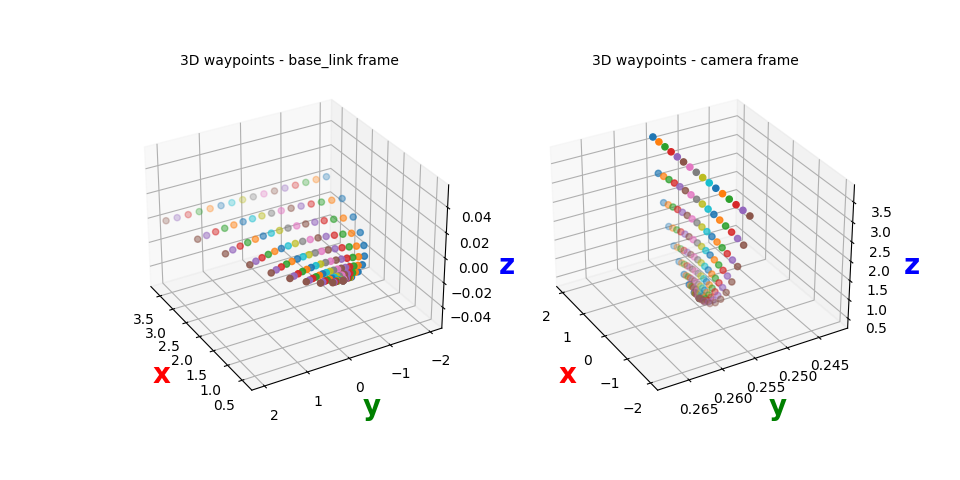

In [38]:
depth.plot_traj()

## Project Image Waypoints

<IPython.core.display.Javascript object>


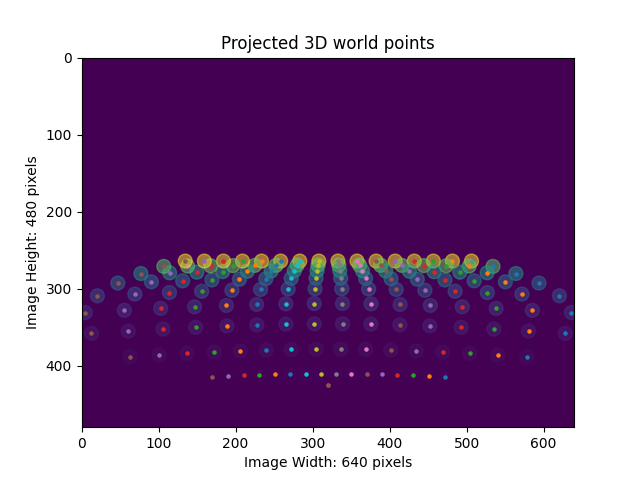

In [39]:
depth.project_points()